In [2]:
import os
import glob
import re
import ants

import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

in_container=True
DATADIR = "/DATA" if in_container else "/BEE/Connectome"
raw_data_path = "/theia_archive/HCP_Data/*/T1w/T1w_acpc_dc.nii.gz"
processed_data_path = f"/{DATADIR}/Users/amahmood/braintyp/processed_v2/"
segs_dir = f"/{DATADIR}/Users/amahmood/braintyp/segs/"

In [6]:
ls -ailh $processed_data_path | grep HCP | head

19334285574 -rw-r--r--.  1 amahmood 1001 8.7M Oct 28 13:39 HCP100307.nii.gz
19334285577 -rw-r--r--.  1 amahmood 1001  11M Oct 28 13:41 HCP100408.nii.gz
19334285578 -rw-r--r--.  1 amahmood 1001 8.8M Oct 28 13:43 HCP101107.nii.gz
19334285579 -rw-r--r--.  1 amahmood 1001 9.5M Oct 28 13:45 HCP101309.nii.gz
19334285580 -rw-r--r--.  1 amahmood 1001 8.9M Oct 28 13:47 HCP101915.nii.gz
19334285581 -rw-r--r--.  1 amahmood 1001  11M Oct 28 13:48 HCP103111.nii.gz
19334285582 -rw-r--r--.  1 amahmood 1001 8.4M Oct 28 13:50 HCP103414.nii.gz
19334285583 -rw-r--r--.  1 amahmood 1001 8.4M Oct 28 13:52 HCP103818.nii.gz
19334285584 -rw-r--r--.  1 amahmood 1001 9.3M Oct 28 13:54 HCP105014.nii.gz
19334285585 -rw-r--r--.  1 amahmood 1001 9.8M Oct 28 13:55 HCP105115.nii.gz
grep: write error: Broken pipe


In [4]:
# dirs = glob.glob(f"{raw_data_path}/*/*")
# ages = [p.split("/")[-1] for p in dirs]
# Counter(ages)

### No WM segmentations, so heuristic

In [8]:
img_paths = glob.glob(f"{processed_data_path}/HCP*[0-9].nii.gz")
subids = [re.search(r"(HCP\d*)\.nii", p).group(1) for p in img_paths]
len(img_paths), img_paths[0], subids[0]

(100,
 '//DATA/Users/amahmood/braintyp/processed_v2/HCP100307.nii.gz',
 'HCP100307')

In [9]:
%%time
t1_means, t1_stds = [], []
t2_means, t2_stds = [], []

for p in tqdm(img_paths):
    img = ants.image_read(p)
    t1,t2 = img.split_channels()
    t1_means.append(t1.mean())
    t1_stds.append(t1.std())

    t2_means.append(t2.mean())
    t2_stds.append(t2.std())

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]

CPU times: user 1min 9s, sys: 3.09 s, total: 1min 12s
Wall time: 1min 25s


In [10]:
t1_wm_means = pd.Series(t1_means, index=subids)
t2_wm_means = pd.Series(t2_means, index=subids)

<Axes: >

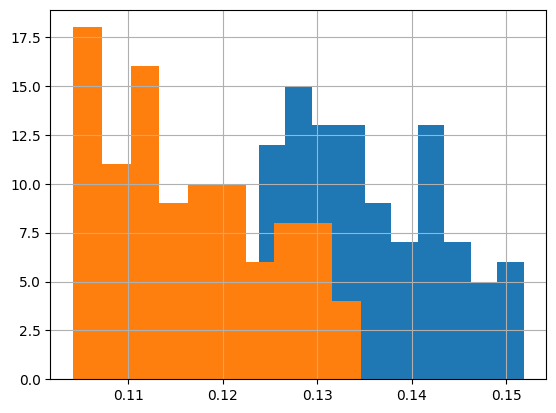

In [11]:
t1_wm_means.hist()
t2_wm_means.hist()

In [12]:
t1_wm_stds = pd.Series(t1_stds, index=subids)
t2_wm_stds = pd.Series(t2_stds, index=subids)

<Axes: >

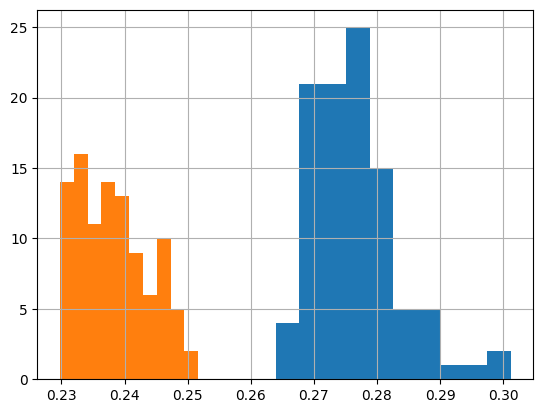

In [13]:
t1_wm_stds.hist()
t2_wm_stds.hist()

In [14]:
t1_mu = t1_wm_means.dropna().mean()
t1_std = t1_wm_means.dropna().std()

print(f"T1 Means: mu: {t1_mu:.3f} w/ std {t1_std:.3f}")

T1 Means: mu: 0.136 w/ std 0.008


In [15]:
t1_stds_mu = t1_wm_stds.mean()
t1_stds_std = t1_wm_stds.std()

print(f"T1 Stds: {t1_stds_mu:.3f} w/ std {t1_stds_std:.3f}")

T1 Stds: 0.277 w/ std 0.007


In [27]:
mult = 3
t1_mu_candidates = (t1_wm_means > (t1_mu + mult*t1_std)) | (t1_wm_means < (t1_mu - mult*t1_std))
t1_std_candidates = (t1_wm_stds > (t1_stds_mu + mult*t1_stds_std)) | (t1_wm_stds < (t1_stds_mu - mult*t1_stds_std))
t1_candidates = t1_mu_candidates | t1_std_candidates
t1_outliers = np.argwhere(t1_candidates.to_numpy()).flatten()
len(t1_outliers)

3

In [28]:
t1_inliers = np.argwhere(~t1_candidates.to_numpy()).flatten()
len(t1_outliers) + len(t1_inliers)

100

HCP111312: //DATA/Users/amahmood/braintyp/processed_v2//HCP111312.nii.gz


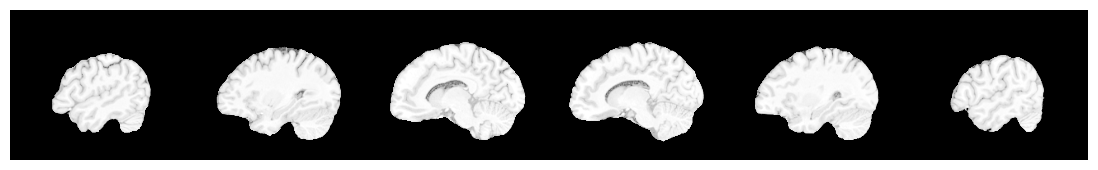

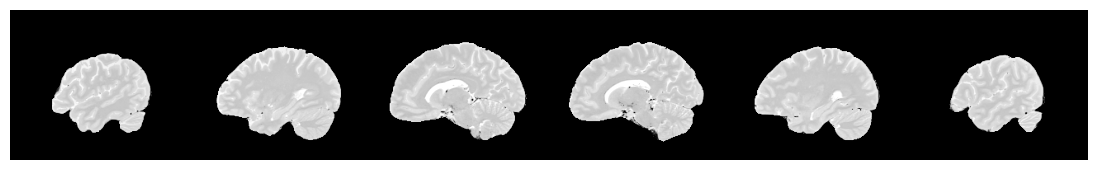

HCP118528: //DATA/Users/amahmood/braintyp/processed_v2//HCP118528.nii.gz


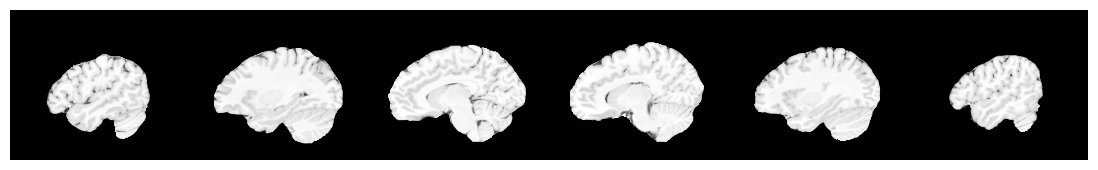

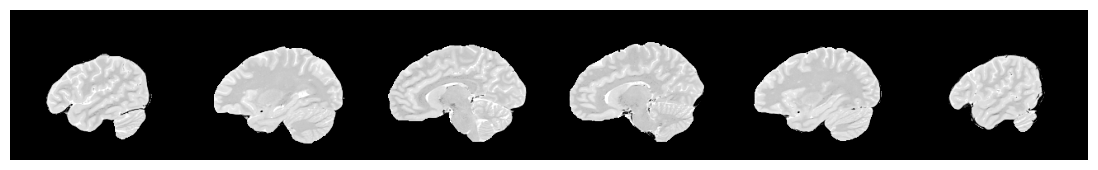

HCP756055: //DATA/Users/amahmood/braintyp/processed_v2//HCP756055.nii.gz


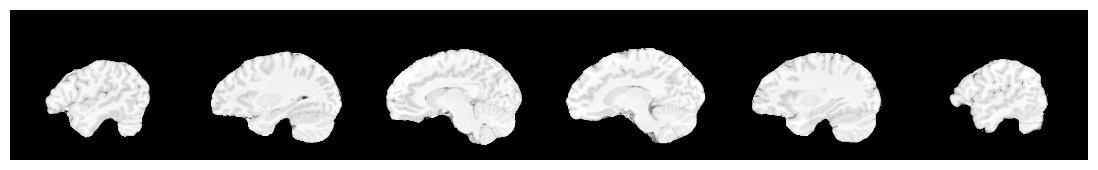

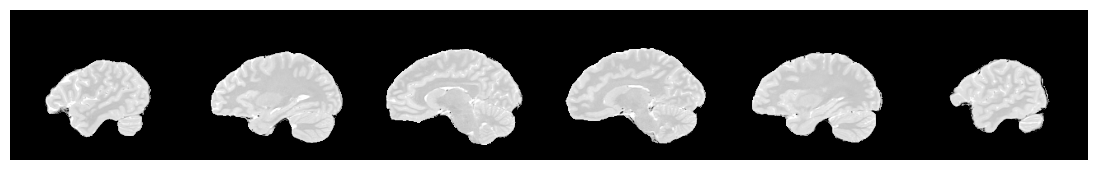

In [29]:
for tidx in t1_outliers[:4]:
    sid = t1_wm_means.index[tidx]
#     path = glob.glob(f"{raw_data_path}/{sid[4:]}/*/anat/*")[-1]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")

    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

### T2

In [30]:
t2_mu = t2_wm_means.dropna().mean()
t2_std = t2_wm_means.dropna().std()

In [31]:
print(f"Mean: {t2_mu:.3f} w/ std {t2_std:.3f}")

Mean: 0.116 w/ std 0.009


In [32]:
t2_stds_mu = t2_wm_stds.mean()
t2_stds_std = t2_wm_stds.std()

print(f"Mean: {t2_stds_mu:.3f} w/ std {t2_stds_std:.3f}")

Mean: 0.238 w/ std 0.006


In [33]:
mult = 3
t2_mu_candidates = (t2_wm_means > (t2_mu + mult*t2_std)) | (t2_wm_means < (t2_mu - mult*t2_std))
t2_std_candidates = (t2_wm_stds > (t2_stds_mu + mult*t2_stds_std)) | (t2_wm_stds < (t2_stds_mu - mult*t2_stds_std))
t2_candidates = t2_mu_candidates | t2_std_candidates
t2_outliers = np.argwhere(t2_candidates.to_numpy()).flatten()
len(t2_outliers)

0

In [34]:
for tidx in t2_outliers[:4]:
    sid = t2_wm_means.index[tidx]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")
    
#     t1_outlier_img = ants.image_read(path)
#     t1_outlier_img.plot(nslices=6)
    
    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))    
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

In [35]:
t1_drop_samples = t1_wm_means.index[t1_outliers].to_list()
t2_drop_samples = t2_wm_means.index[t2_outliers].to_list()
drop_samples = set(t1_drop_samples).union(set(t2_drop_samples))
len(drop_samples)

3

In [36]:
len(t1_wm_means)

100

In [37]:
hcp_passing_keys = pd.Series(t1_wm_means.dropna().index)
hcp_passing_keys.to_csv('../split-keys/hcp_keys.txt', header=None, index=None)